# ДЗ к Урок 5.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from tqdm import tqdm

from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

%matplotlib inline
pd.set_option("display.max_rows", 500)

## Описание задачи

Мы работаем в Банке / Телеоператоре, у нашей компании есть клиенты, которые должны вносить платеж по кредиту / вносить абонентскую плату за услуги связи до фиксированной даты каждого месяца (например: до 20-го числа каждого месяца). Некоторые клиенты вносят оплаты заблоговременно, другие клиенты вносят оплаты в дату предполагаемой оплаты, некоторые забывают и вносят позже. Мы ожидаем, что клиенты будут вносить оплату вовремя, исходя из этой гипотезы, мы строим финансовую стратегию работы компании. Для улучшения ситуации, мы хотим информировать клиентов о приближающейся дате оплаты платежа / абоненской платы. При этом, у нас есть несколько способов коммуникации с клиентами: __SMS__, __звонок человека__, __IVR__ (звонок робота) или ничего не делать. При этом каждый вид взаимодействия стоит нам определенных денег, и у нас есть ограничение на количество способов взаимодействия каждым способом. __Например__, если в Call-центре компании работает 100 сотрудников, каждый из которых может совершить 30 звонков в день, то более 3000 звонков в день мы сделать не можем. Или, есть у нас есть бюджет 100.000 рублей на отправку SMS-коммуникации, то при стоимости одного SMS - 2 рубля, мы не можем отправить более 50.000 SMS-сообщений в день. И так далее. __ЦЕЛЬ__ состоит в том, чтобы оптимизировать коммуникацию с клиентами, то есть максимизировать долю клиентов, которые исполняют свои обязанности вовремя, при этом затратив на это минимальное количество средств.

__План решения__ состоит из трех основных этапов:
* построить ML-модели для оценки вероятности внесения платежа при коммуникации указанным способом;
* оценить финансовый эффект от взаимодействия указанным способом;
* назначить каждому клиенту 1 вид взаимодействия для максимизации указанных в описании задачи метрик.

__Данные__:
для решения такой задачи, нам нужны данные, из которых была бы понятна эффективность каждого конкретного метода взаимодействия. Для сбора таких данных можно поступить следующим образом: выбрать небольшую часть репрезентативной выборки клиентов, и каждому клиенту случайным образом, назначать вид коммуникации с соблюдением заданных ограничений на количество доступных звонков / бюджет на SMS / и т.д. После завершение эксперимента, у нас будут данные для обучения модели. 

In [2]:
data = pd.read_csv("train.csv")
test = pd.read_csv("valid.csv")

data.head(n=2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,COMMUNICATION_TYPE
0,176207,0,Cash loans,M,Y,N,0,135000.0,450000.0,27193.5,...,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,PUSH
1,425123,0,Cash loans,F,N,Y,1,193500.0,295668.0,11277.0,...,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0,SMS


In [3]:
gp = data[["COMMUNICATION_TYPE", "TARGET"]]
gp_stats = gp.groupby(["COMMUNICATION_TYPE"]).agg({"TARGET": ["count", "mean", "sum"]})
gp_stats.columns = ["OBSERVERS", "EVENTRATE", "EVENTS"]
gp_stats = gp_stats.reset_index()

gp_stats

,COMMUNICATION_TYPE,OBSERVERS,EVENTRATE,EVENTS
0,CALL,3439,0.078802,271
1,IVR,7185,0.067084,482
2,None,3336,0.056055,187
3,PUSH,126096,0.085586,10792
4,SMS,44450,0.071001,3156


## 1. Обучение моделей

Обучим 5 моделей для оценки вероятности НЕ внесения платежа при заданном типе коммуникации

In [4]:
numerical_features = data.select_dtypes(exclude=["object"]).columns.tolist() + ["COMMUNICATION_TYPE"]
X, y = data[numerical_features].drop(["SK_ID_CURR", "TARGET"], axis=1), data["TARGET"]

In [5]:
x_train, x_test = train_test_split(
    X, train_size=0.7, random_state=1
)
y_train, y_test = train_test_split(
    y, train_size=0.7, random_state=1
)

In [6]:
def fit_model(X: pd.DataFrame,
              y: pd.Series,
              communication_type: str,
              estimator,
              fillna=-9999
              ):
    """
    Обучение модели под отдельный вид коммуникации.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame, shape = [n_samples, n_features]
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series, shape = [n_samples, 1]
        Вектор целевой переменной для обучения модели.

    communication_type: str
        Вид коммуникации: "CALL", "IVR", "SMS", "PUSH", "None".

    estimator: sklearn.callable
        Объект Estimator, поддерживающий API sklearn.

    fillna: int/float, optional, default = -9999
        Значение для заполнение пропусков в матрице признаков.
        Опциональный параметр, по умолчанию, равен -9999.

    Returns
    -------
    model: sklearn.callable
        Объект обученной модели.

    """
    mask = X["COMMUNICATION_TYPE"] == communication_type
    x_train = X.drop("COMMUNICATION_TYPE", axis=1)
    x_train, y_train = x_train.loc[mask], y.loc[mask]

    print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
    model = estimator.fit(x_train.fillna(fillna), y_train)

    return model


def evaluate_model(X: pd.DataFrame,
                   y: pd.Series,
                   communication_type: str,
                   estimator,
                   fillna=-9999
                   ) -> float:
    """
    Оценка качества модели с помощью метрики ROC-AUC.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame, shape = [n_samples, n_features]
        Матрица признаков для оценки модели.

    y: pandas.core.frame.Series, shape = [n_samples, 1]
        Вектор целевой переменной для оценки модели.

    communication_type: str
        Вид коммуникации: "CALL", "IVR", "SMS", "PUSH", "None".

    estimator: sklearn.callable
        Объект Estimator, к которому был применен метод fit.

    fillna: int/float, optional, default = -9999
        Значение для заполнение пропусков в матрице признаков.
        Опциональный параметр, по умолчанию, равен -9999.

    Returns
    -------
    score: float
        Значение метрики ROC-AUC.

    """
    check_is_fitted(estimator)

    mask = X["COMMUNICATION_TYPE"] == communication_type
    x_test = X.drop("COMMUNICATION_TYPE", axis=1)
    x_test, y_test = x_test.loc[mask], y.loc[mask]

    y_pred = estimator.predict_proba(x_test.fillna(fillna))
    score = roc_auc_score(y_test, y_pred[:, 1])

    return score

In [7]:
models = {}

params = {
    "n_estimators": 250,
    "max_depth": 3,
    "random_state": 27,
    "n_jobs": 6
}

for comm_type in ["CALL", "None"]:

    model = fit_model(
        X=x_train,
        y=y_train,
        communication_type=comm_type,
        estimator=RandomForestClassifier(**params)
    )
    models[f"{comm_type}_model"] = model

x_train.shape = 2413 rows, 104 cols
x_train.shape = 2369 rows, 104 cols


In [8]:
# Оценка качества модели

for comm_type in ["CALL", "None"]:
    model = models[f"{comm_type}_model"]
    score = evaluate_model(
        X=x_test,
        y=y_test,
        communication_type=comm_type,
        estimator=model
    )
    print(f"Communication: {comm_type}, Score: {score}")

Communication: CALL, Score: 0.6925881649731023
Communication: None, Score: 0.6552424113676061


## 2. Применение моделей к тестовому набору данных

Применим все построенные модели к тестовым данным, таким образом, мы получим вероятность дефолта (не внесения платежа) при коммуникации указанным способом. После чего, умножим вероятность дефолта на сумму платежа, таким образом мы получим математическое ожидание потерь при взаимодействии каждым способом. Наша задача минимизировать ожидаемые потери или максимизировать ожидаемую сумму поступающих платежей. Это одно и то же.

In [9]:
def create_predictions(models: dict, X: pd.DataFrame, fillna=-9999) -> pd.DataFrame:
    """
    Применение семейства моделей к набору данных X.

    Parameters
    ----------
    models: Dict[estimator]
        Словарь с экземплярами обученных моделей.

    X: pandas.core.frame.DataFrame, shape = [n_samples, n_features]
        Матрица признаков для применения модели.

    fillna: int/float, optional, default = -9999
        Значение для заполнение пропусков в матрице признаков.
        Опциональный параметр, по умолчанию, равен -9999.

    Returns
    -------
    y_pred: pandas.core.frame.DataFrame, shape = [n_samples, len(models)]
        Матрица с прогнозами всех моделей.

    """
    y_pred = pd.DataFrame()
    for model in models:
        estimator = models[model]
        score = estimator.predict_proba(X.fillna(fillna))[:, 1]
        name = model.split("_")[0]
        y_pred[f"{name}_SCORE"] = score

    return y_pred

def calculate_expected_losses(scores: pd.DataFrame, X: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисление матрицы ожидаемых потерь при взаимодействии
    каждым способом. Вычисляется как произведение вероятности
    дефолта на величину платежа.

    Parameters
    ----------
    scores: pandas.core.frame.DataFrame
        Матрица вероятностей дефолта.

    X: pandas.core.frame.DataFrame
        Матрица признаков для применения модели.

    Returns
    -------
    losses: pandas.core.frame.DataFrame
        Матрица ожидаемых потерь.

    """
    scores["SK_ID_CURR"] = X["SK_ID_CURR"]
    scores["AMT_ANNUITY"] = X["AMT_ANNUITY"]
    scores_columns = [col for col in scores.columns if "SCORE" in col]

    for score in scores_columns:
        name = score.split("_")[0]
        name = f"EXPECTED_LOSS_{name}"

        scores[name] = scores["AMT_ANNUITY"] * scores[score]

    return scores

In [10]:
x_test, y_test = test[x_train.columns], test["TARGET"]
x_test = x_test.drop("COMMUNICATION_TYPE", axis=1)

In [11]:
y_pred_test = create_predictions(models, x_test)
y_pred_test = calculate_expected_losses(y_pred_test, test)
y_pred_test = y_pred_test.dropna().reset_index(drop=True)

y_pred_test.head(n=2)

,CALL_SCORE,None_SCORE,SK_ID_CURR,AMT_ANNUITY,EXPECTED_LOSS_CALL,EXPECTED_LOSS_None
0,0.093682,0.061864,174545,31617.0,2961.946876,1955.939001
1,0.103857,0.076107,209898,25393.5,2637.294134,1932.614798


## Визуализируем данные для понимания распределений

[]

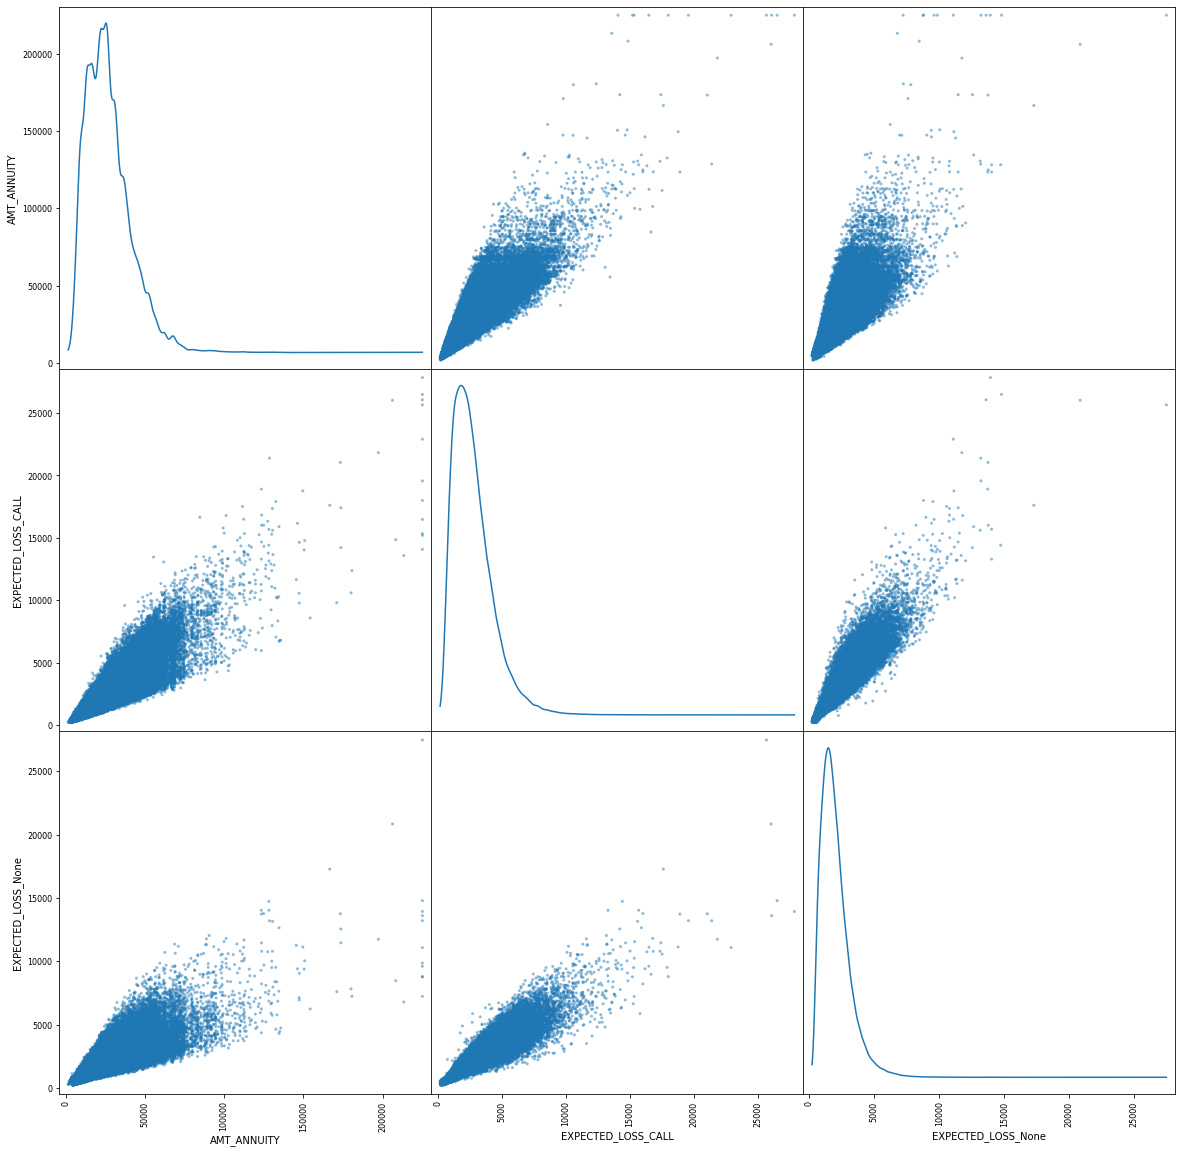

In [12]:
figsize = (20, 20)

cols_to_plot = [
    "AMT_ANNUITY",
    "EXPECTED_LOSS_CALL",
    "EXPECTED_LOSS_None"
]

scatter_matrix(
    frame=y_pred_test[cols_to_plot],
    figsize=figsize,
    diagonal="kde"
)
plt.plot()

## 3. Оптимизация типа взаимодействия

In [37]:
stuffdict = {idx: (int(y_pred_test.loc[idx,  "EXPECTED_LOSS_CALL"]), 1)  for idx in y_pred_test.index}


## 4. Создание списка значений площади и ценности

Разделяем списки значений исходного словаря, например так:

In [38]:
def get_area_and_values(stuffdict: dict):
    area = [value[1] for value in stuffdict.values()]
    value = [value[0] for value in stuffdict.values()]

    return area, value

## 5. Используем списки для мемоизации

Пусть $n$ - общее число возможных коммуникаций, $А$ - их максимально допустимые затраты на коммуникации. Составим таблицу и $n + 1$ строк и $А + 1$ столбцов. Строки пронумеруем индексом $i$, столбцы - $a$, то есть в качестве номеров столбцов мы рассматриваем дискретные значения площади, отличающиеся друг от друга на 1.

In [39]:
def get_memtable(stuffdict, A: int = 200):
    area, value = get_area_and_values(stuffdict)
    n = len(value)

    v = [[0 for a in range(A+1)] for i in range(n+1)]
    for i in tqdm(range(n + 1)):
        for a in range(A + 1):
            if i == 0 or a == 0:
                v[i][a] = 0 # базовый кейс

            elif area[i-1] <= a:
                # если площадь предмета меньше площади столбца
                # то максимизируем значение суммарной ценности
                v[i][a] = max(value[i-1] + v[i-1][a-area[i-1]], v[i-1][a])
    
            else:
                # если площадь предмента больше площади столбца
                # забираем значение ячейки из предыдущей строки
                v[i][a] = v[i-1][a]
    
    return v, area, value

Вначале создаем и заполняем таблицу в виде вложенных списков. Нулевую строку и нулевой столбец заполняем нулями. Это базовый случай: когда площадь или количество элементов равны нулю, значения ячейки равно нулю. Далее таблица значений будет заполняться строка за строкой слева направо и сверхну вниз. Если площадь текущего элемента меньше или равна площади текущей ячейки, вычислем значение ячейки следую правилу: `v[i][a] = max(value[i-1] + v[i-1][a-area[i-1]], v[i-1][a])`.

Выбираем максимальное значение из двух значений:
* сумма ценности текущего предмета `value[i-1]` и величины элемента из предыдущей строки `i-1` с площадью, меньшей на величину текущего предмета `area[i-1]`.
* значение элемента предыдущей строки с той же площадью, то есть из того же столбца, что текущая ячейка. То же значение устанавливается в случае, если площадь текущей ячейки меньше, чем площадь текущего элемента.

In [40]:
def get_selected_items_list(stuffdict, A=200):
    v, area, value = get_memtable(stuffdict)
    n, res = len(value), v[len(value)][A]
    a, items_list = A, []

    for i in range(n, 0, -1):
        if res <= 0:
            break
        if res == v[i-1][a]:
            continue
        else:
            items_list.append((value[i-1], area[i-1]))
            res -= value[i-1]
            a -= area[i-1]
    items_list = set(items_list)

    selected_stuff = []
    for search in items_list:
        for key, value in stuffdict.items():
            if value == search:
                selected_stuff.append(key)

    return selected_stuff

In [41]:
# найденный оптимальный список предметов
stuff = get_selected_items_list(stuffdict, A=200)


100%|████████████████████████████████████████████████████████████████████████████████████| 123003/123003 [00:18<00:00, 6527.61it/s]


In [42]:
# проверим суммарную площадь и ценности предметов
total_area = sum([stuffdict[item][0] for item in stuff])
total_value = sum([stuffdict[item][1] for item in stuff])

print(f"total_area = {total_area}")
print(f"total_value  {total_value}")

total_area = 2697221
total_value  200


In [43]:
# визуализация результат оптимизации
def plot_memtable(V, stuffdict):
    plt.figure(figsize=(30,15))
    item_list = list(stuffdict.keys())
    item_list.insert(0, 'empty')
    sns.heatmap(V, yticklabels=item_list)
    plt.yticks(size=25)
    plt.xlabel('Area', size=25)
    plt.ylabel('Added item', size=25)
    plt.title('Value for Area with Set of Items', size=30)
    plt.show()

In [ ]:
v, area, value = get_memtable(stuffdict)
plot_memtable(v, stuffdict)

100%|████████████████████████████████████████████████████████████████████████████████████| 123003/123003 [00:18<00:00, 6698.28it/s]
